## 라이브러리 구성

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [4]:
# 데이터 로드
tr = pd.read_csv('data/train.csv')
te = pd.read_csv('data/test.csv')

## 데이터 전처리

**코드오류 데이터 제거**
- 'C2085', 'C1397', 'C2431', 'C1649','C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'

In [3]:
#오류 단지 번호 리스트
err =list()
err = ['C2085', 'C1397', 'C2431', 'C1649','C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

#오류 행 제거
for i in err:
    tr.drop(tr[tr["단지코드"] == i].index,inplace = True)

#### 서울특별시 데이터 학습 데이터셋에서 제거 (테스트 데이터셋에 존재하지 않음)

In [4]:
#서울특별시 데이터 학습 데이터셋에서 제거 (테스트 데이터셋에 존재하지 않음)
#tr = tr.loc[tr.지역 != '서울특별시']

공급유형 == 임대상가 -> 임대보증금, 임대료 0으로 대치

In [5]:
#임대보증금, 임대료 임대상가 대치
tr.loc[tr.공급유형 == "임대상가","임대보증금"] = 0
tr.loc[tr.공급유형 == "임대상가","임대료"] = 0

te.loc[te.공급유형 == "임대상가","임대보증금"] = 0
te.loc[te.공급유형 == "임대상가","임대료"] = 0

In [6]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2862 non-null   object 
 10  임대료                           2862 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2662 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

지하철, 버스정류장 이름 변경

In [7]:
#지하철, 버스정류장 이름 변경
tr.rename(columns={"도보 10분거리 내 지하철역 수(환승노선 수 반영)" : "지하철", "도보 10분거리 내 버스정류장 수" : "버스"}, inplace=True)
te.rename(columns={"도보 10분거리 내 지하철역 수(환승노선 수 반영)" : "지하철", "도보 10분거리 내 버스정류장 수" : "버스"}, inplace=True)

테스트데이터 자격유형 결측치 정의

In [8]:
te.loc[196,"자격유형"] = "A"
te.loc[258,"자격유형"] = "C"

In [9]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   공급유형      2869 non-null   object 
 5   전용면적      2869 non-null   float64
 6   전용면적별세대수  2869 non-null   int64  
 7   공가수       2869 non-null   float64
 8   자격유형      2869 non-null   object 
 9   임대보증금     2862 non-null   object 
 10  임대료       2862 non-null   object 
 11  지하철       2662 non-null   float64
 12  버스        2869 non-null   float64
 13  단지내주차면수   2869 non-null   float64
 14  등록차량수     2869 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 358.6+ KB


임대보증금 결측치 train = 7, test = 3

In [10]:
for i in tr.loc[tr.임대료.isna(),"단지코드"].unique():
    display(tr.loc[tr.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,NaN,NaN,NaN,6.0,1636.0,2315.0
2338,C1350,1401,아파트,대전광역시,공공임대(10년),51.99,106,2.0,A,28013000,408600,NaN,6.0,1636.0,2315.0
2339,C1350,1401,아파트,대전광역시,공공임대(10년),59.91,13,2.0,A,37474000,519350,NaN,6.0,1636.0,2315.0
2340,C1350,1401,아파트,대전광역시,공공임대(10년),59.92,223,2.0,A,37385000,516130,NaN,6.0,1636.0,2315.0


In [11]:
for i in te.loc[te.임대료.isna(),"단지코드"].unique():
    display(te.loc[te.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
73,C1006,1505,아파트,대전광역시,영구임대,26.37,358,27.0,C,5787000,79980,2.0,5.0,428.0
74,C1006,1505,아파트,대전광역시,영구임대,26.37,229,27.0,C,5787000,79980,2.0,5.0,428.0
75,C1006,1505,아파트,대전광역시,영구임대,26.37,574,27.0,C,5787000,79980,2.0,5.0,428.0
76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27.0,D,NaN,NaN,2.0,5.0,428.0
78,C1006,1505,아파트,대전광역시,영구임대,31.32,298,27.0,C,6873000,94990,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27.0,D,NaN,NaN,2.0,5.0,428.0
80,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,0,0,2.0,5.0,428.0
81,C1006,1505,상가,대전광역시,임대상가,38.00,1,27.0,D,0,0,2.0,5.0,428.0
82,C1006,1505,상가,대전광역시,임대상가,37.26,1,27.0,D,0,0,2.0,5.0,428.0


자격유형 D는 모두 임대보증금, 임대료가 0이다.

In [12]:
#따라서 자격유형 D의 임대보증금, 임대료는 모두 0으로 대치
tr.loc[tr.자격유형 == "D","임대보증금"] = 0
tr.loc[tr.자격유형 == "D","임대료"] = 0
te.loc[te.자격유형 == "D","임대보증금"] = 0
te.loc[te.자격유형 == "D","임대료"] = 0

임대료랑 임대보증금에 특이값이 존재했던거 같은데 => **특이값 추가적으로 확인**

In [13]:
for i in tr.loc[tr.임대료 == '-',"단지코드"].unique():
    display(tr.loc[tr.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,645.0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,645.0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,645.0
2103,C1039,790,아파트,서울특별시,국민임대,26.68,26,13.0,A,15282000,190620,0.0,3.0,673.0,645.0
2104,C1039,790,아파트,서울특별시,국민임대,36.70,140,13.0,A,21024000,256040,0.0,3.0,673.0,645.0
2105,C1039,790,아파트,서울특별시,국민임대,36.70,14,13.0,A,21024000,256040,0.0,3.0,673.0,645.0
2106,C1039,790,아파트,서울특별시,국민임대,36.87,43,13.0,A,21024000,256040,0.0,3.0,673.0,645.0
2107,C1039,790,아파트,서울특별시,국민임대,46.76,192,13.0,A,45456000,356420,0.0,3.0,673.0,645.0
2108,C1039,790,아파트,서울특별시,국민임대,46.96,25,13.0,A,45456000,356420,0.0,3.0,673.0,645.0
2109,C1039,790,아파트,서울특별시,영구임대,26.68,70,13.0,I,11490000,94820,0.0,3.0,673.0,645.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2547,C1326,1934,아파트,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2548,C1326,1934,아파트,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2549,C1326,1934,아파트,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2550,C1326,1934,아파트,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2551,C1326,1934,아파트,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1153.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2680,C1786,480,아파트,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,345.0
2684,C1786,480,아파트,강원도,행복주택,36.91,92,25.0,J,30560000,145160,0.0,3.0,338.0,345.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2906,C2186,924,아파트,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,744.0
2907,C2186,924,아파트,대구광역시,국민임대,29.34,38,0.0,H,-,-,0.0,8.0,664.0,744.0
2908,C2186,924,아파트,대구광역시,국민임대,37.43,220,0.0,H,-,-,0.0,8.0,664.0,744.0
2909,C2186,924,아파트,대구광역시,국민임대,46.51,188,0.0,H,25981000,248630,0.0,8.0,664.0,744.0
2910,C2186,924,아파트,대구광역시,영구임대,26.37,219,0.0,C,13126000,105870,0.0,8.0,664.0,744.0
2911,C2186,924,아파트,대구광역시,영구임대,26.54,13,0.0,C,13164000,106190,0.0,8.0,664.0,744.0


In [14]:
for i in te.loc[te.임대료 == '-',"단지코드"].unique():
    display(te.loc[te.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
1005,C2152,120,아파트,강원도,영구임대,24.83,66,9.0,C,-,-,0.0,1.0,40.0
1006,C2152,120,아파트,강원도,영구임대,33.84,54,9.0,C,-,-,0.0,1.0,40.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
1007,C1267,675,아파트,경상남도,국민임대,24.87,28,38.0,H,6882000,104370,0.0,1.0,467.0
1008,C1267,675,아파트,경상남도,국민임대,24.99,90,38.0,H,6882000,104370,0.0,1.0,467.0
1009,C1267,675,아파트,경상남도,국민임대,24.99,12,38.0,H,6882000,104370,0.0,1.0,467.0
1010,C1267,675,아파트,경상남도,국민임대,46.72,68,38.0,H,24420000,219230,0.0,1.0,467.0
1011,C1267,675,아파트,경상남도,국민임대,46.72,112,38.0,H,24420000,219230,0.0,1.0,467.0
1012,C1267,675,아파트,경상남도,영구임대,22.86,96,38.0,C,10876000,89230,0.0,1.0,467.0
1013,C1267,675,아파트,경상남도,영구임대,22.86,14,38.0,C,10876000,89230,0.0,1.0,467.0
1014,C1267,675,아파트,경상남도,행복주택,16.94,50,38.0,L,-,-,0.0,1.0,467.0
1015,C1267,675,아파트,경상남도,행복주택,26.85,66,38.0,L,-,-,0.0,1.0,467.0
1016,C1267,675,아파트,경상남도,행복주택,26.85,8,38.0,L,-,-,0.0,1.0,467.0


In [15]:
tr = tr.replace('-',0)
te = te.replace('-',0)
tr.임대보증금 = tr.임대보증금.astype(float)
te.임대보증금 = te.임대보증금.astype(float)
tr.임대료 = tr.임대료.astype(float)
te.임대료 = te.임대료.astype(float)

In [16]:
tr.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,0


In [17]:
te.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,0


In [18]:
tr.지하철.value_counts()

0.0    2223
1.0     400
2.0      33
3.0       6
Name: 지하철, dtype: int64

In [19]:
tr.loc[tr.지하철.isna(),"단지코드"].unique()

array(['C1312', 'C1874', 'C1424', 'C2100', 'C2520', 'C1616', 'C1704',
       'C2258', 'C1068', 'C1983', 'C2216', 'C2644', 'C1005', 'C1004',
       'C1875', 'C2156', 'C1175', 'C2583', 'C1350'], dtype=object)

In [20]:
for i in tr.loc[tr.지하철.isna(),"단지코드"].unique():
    display(tr.loc[tr.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
94,C1312,518,아파트,충청남도,국민임대,39.72,60,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0
95,C1312,518,아파트,충청남도,국민임대,39.98,89,12.0,A,17460000.0,122210.0,NaN,3.0,527.0,359.0
96,C1312,518,아파트,충청남도,국민임대,41.55,225,12.0,A,19954000.0,130940.0,NaN,3.0,527.0,359.0
97,C1312,518,아파트,충청남도,국민임대,46.90,143,12.0,A,28687000.0,149660.0,NaN,3.0,527.0,359.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
98,C1874,619,아파트,충청남도,영구임대,26.37,294,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0
99,C1874,619,아파트,충청남도,영구임대,26.37,149,2.0,C,3141000.0,69900.0,NaN,2.0,97.0,62.0
100,C1874,619,아파트,충청남도,영구임대,31.32,149,2.0,C,3731000.0,83020.0,NaN,2.0,97.0,62.0
101,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0
102,C1874,619,상가,충청남도,임대상가,17.40,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0
103,C1874,619,상가,충청남도,임대상가,17.40,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0
104,C1874,619,상가,충청남도,임대상가,22.89,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0
105,C1874,619,상가,충청남도,임대상가,23.13,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0
106,C1874,619,상가,충청남도,임대상가,23.13,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0
107,C1874,619,상가,충청남도,임대상가,23.25,1,2.0,D,0.0,0.0,NaN,2.0,97.0,62.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
144,C1424,625,아파트,대전광역시,공공임대(50년),39.99,268,2.0,A,14247000.0,198980.0,NaN,7.0,517.0,179.0
145,C1424,625,아파트,대전광역시,공공임대(50년),49.95,119,2.0,A,20173000.0,225100.0,NaN,7.0,517.0,179.0
146,C1424,625,아파트,대전광역시,공공임대(50년),49.95,237,2.0,A,21203000.0,225100.0,NaN,7.0,517.0,179.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
147,C2100,880,아파트,대전광역시,국민임대,51.51,46,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0
148,C2100,880,아파트,대전광역시,국민임대,51.59,35,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0
149,C2100,880,아파트,대전광역시,국민임대,51.90,589,4.0,A,22307000.0,89210.0,NaN,5.0,736.0,671.0
150,C2100,880,아파트,대전광역시,국민임대,59.91,118,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0
151,C2100,880,아파트,대전광역시,국민임대,59.94,46,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0
152,C2100,880,아파트,대전광역시,국민임대,59.99,46,4.0,A,27885000.0,111520.0,NaN,5.0,736.0,671.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
171,C2520,970,아파트,대전광역시,공공임대(50년),39.69,960,2.0,A,13155000.0,177500.0,NaN,2.0,420.0,386.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
176,C1616,1507,아파트,대전광역시,영구임대,26.37,588,1.0,C,5787000.0,79980.0,NaN,2.0,407.0,98.0
177,C1616,1507,아파트,대전광역시,영구임대,31.32,450,1.0,C,6873000.0,94990.0,NaN,2.0,407.0,98.0
178,C1616,1507,아파트,대전광역시,영구임대,40.32,450,1.0,E,54040000.0,28140.0,NaN,2.0,407.0,98.0
179,C1616,1507,상가,대전광역시,임대상가,38.00,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0
180,C1616,1507,상가,대전광역시,임대상가,38.00,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0
181,C1616,1507,상가,대전광역시,임대상가,37.26,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0
182,C1616,1507,상가,대전광역시,임대상가,37.41,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0
183,C1616,1507,상가,대전광역시,임대상가,37.41,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0
184,C1616,1507,상가,대전광역시,임대상가,37.41,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0
185,C1616,1507,상가,대전광역시,임대상가,37.49,1,1.0,D,0.0,0.0,NaN,2.0,407.0,98.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
198,C1704,639,아파트,대전광역시,영구임대,39.30,204,34.0,C,8625000.0,119190.0,NaN,7.0,162.0,131.0
199,C1704,639,아파트,대전광역시,영구임대,39.69,420,34.0,C,8710000.0,120370.0,NaN,7.0,162.0,131.0
200,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
201,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
202,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
203,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
204,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
205,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
206,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0
207,C1704,639,상가,대전광역시,임대상가,31.84,1,34.0,D,0.0,0.0,NaN,7.0,162.0,131.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
215,C2258,965,아파트,대전광역시,영구임대,26.37,588,13.0,C,5787000.0,79980.0,NaN,3.0,287.0,78.0
216,C2258,965,아파트,대전광역시,영구임대,31.32,180,13.0,C,6873000.0,94990.0,NaN,3.0,287.0,78.0
217,C2258,965,아파트,대전광역시,영구임대,40.32,180,13.0,C,8848000.0,122290.0,NaN,3.0,287.0,78.0
218,C2258,965,상가,대전광역시,임대상가,19.00,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0
219,C2258,965,상가,대전광역시,임대상가,14.10,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0
220,C2258,965,상가,대전광역시,임대상가,19.31,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0
221,C2258,965,상가,대전광역시,임대상가,21.19,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0
222,C2258,965,상가,대전광역시,임대상가,21.19,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0
223,C2258,965,상가,대전광역시,임대상가,22.95,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0
224,C2258,965,상가,대전광역시,임대상가,23.40,1,13.0,D,0.0,0.0,NaN,3.0,287.0,78.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
347,C1068,806,아파트,충청남도,국민임대,36.65,200,11.0,A,11234000.0,106090.0,NaN,2.0,804.0,510.0
348,C1068,806,아파트,충청남도,국민임대,36.98,130,11.0,A,11234000.0,106090.0,NaN,2.0,804.0,510.0
349,C1068,806,아파트,충청남도,국민임대,41.55,252,11.0,A,14981000.0,124830.0,NaN,2.0,804.0,510.0
350,C1068,806,아파트,충청남도,국민임대,46.86,44,11.0,A,18726000.0,149810.0,NaN,2.0,804.0,510.0
351,C1068,806,아파트,충청남도,국민임대,46.98,88,11.0,A,18726000.0,149810.0,NaN,2.0,804.0,510.0
352,C1068,806,아파트,충청남도,국민임대,51.93,91,11.0,A,24343000.0,168520.0,NaN,2.0,804.0,510.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
353,C1983,903,아파트,충청남도,공공임대(50년),36.00,40,3.0,A,10363000.0,149010.0,NaN,4.0,200.0,253.0
354,C1983,903,아파트,충청남도,공공임대(50년),35.28,198,3.0,A,10060000.0,145290.0,NaN,4.0,200.0,253.0
355,C1983,903,아파트,충청남도,공공임대(50년),35.28,78,3.0,A,10060000.0,145290.0,NaN,4.0,200.0,253.0
356,C1983,903,아파트,충청남도,영구임대,26.37,478,3.0,C,8083000.0,124180.0,NaN,4.0,200.0,253.0
357,C1983,903,아파트,충청남도,영구임대,31.32,99,3.0,C,9670000.0,142850.0,NaN,4.0,200.0,253.0
358,C1983,903,상가,충청남도,임대상가,31.84,1,3.0,D,0.0,0.0,NaN,4.0,200.0,253.0
359,C1983,903,상가,충청남도,임대상가,31.84,1,3.0,D,0.0,0.0,NaN,4.0,200.0,253.0
360,C1983,903,상가,충청남도,임대상가,31.84,1,3.0,D,0.0,0.0,NaN,4.0,200.0,253.0
361,C1983,903,상가,충청남도,임대상가,31.84,1,3.0,D,0.0,0.0,NaN,4.0,200.0,253.0
362,C1983,903,상가,충청남도,임대상가,31.84,1,3.0,D,0.0,0.0,NaN,4.0,200.0,253.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
620,C2216,390,아파트,충청남도,공공임대(50년),39.00,210,2.0,A,9401000.0,132480.0,NaN,1.0,97.0,149.0
621,C2216,390,아파트,충청남도,공공임대(50년),39.39,180,2.0,A,9493000.0,133340.0,NaN,1.0,97.0,149.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
640,C2644,779,아파트,충청남도,공공임대(50년),37.67,89,7.0,A,11879000.0,161250.0,NaN,12.0,190.0,177.0
641,C2644,779,아파트,충청남도,공공임대(50년),37.67,298,7.0,A,11879000.0,161250.0,NaN,12.0,190.0,177.0
642,C2644,779,아파트,충청남도,영구임대,26.37,239,7.0,C,8684000.0,127670.0,NaN,12.0,190.0,177.0
643,C2644,779,아파트,충청남도,영구임대,26.37,149,7.0,C,8684000.0,127670.0,NaN,12.0,190.0,177.0
644,C2644,779,상가,충청남도,임대상가,48.90,1,7.0,D,0.0,0.0,NaN,12.0,190.0,177.0
645,C2644,779,상가,충청남도,임대상가,49.72,1,7.0,D,0.0,0.0,NaN,12.0,190.0,177.0
646,C2644,779,상가,충청남도,임대상가,49.72,1,7.0,D,0.0,0.0,NaN,12.0,190.0,177.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
761,C1005,1144,아파트,충청남도,국민임대,51.49,304,16.0,A,16205000.0,208470.0,NaN,8.0,950.0,376.0
762,C1005,1144,아파트,충청남도,국민임대,51.95,600,16.0,A,16348000.0,210900.0,NaN,8.0,950.0,376.0
763,C1005,1144,아파트,충청남도,국민임대,59.64,240,16.0,A,18770000.0,246770.0,NaN,8.0,950.0,376.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
764,C1004,521,아파트,충청남도,영구임대,39.30,240,3.0,C,4682000.0,104180.0,NaN,2.0,153.0,93.0
765,C1004,521,아파트,충청남도,영구임대,39.69,264,3.0,C,4728000.0,105210.0,NaN,2.0,153.0,93.0
766,C1004,521,상가,충청남도,임대상가,19.00,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
767,C1004,521,상가,충청남도,임대상가,14.10,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
768,C1004,521,상가,충청남도,임대상가,19.31,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
769,C1004,521,상가,충청남도,임대상가,21.19,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
770,C1004,521,상가,충청남도,임대상가,21.19,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
771,C1004,521,상가,충청남도,임대상가,22.95,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
772,C1004,521,상가,충청남도,임대상가,23.40,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0
773,C1004,521,상가,충청남도,임대상가,23.40,1,3.0,D,0.0,0.0,NaN,2.0,153.0,93.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
783,C1875,1003,아파트,충청남도,영구임대,26.37,596,5.0,C,3141000.0,69900.0,NaN,8.0,192.0,209.0
784,C1875,1003,아파트,충청남도,영구임대,26.37,239,5.0,C,3141000.0,69900.0,NaN,8.0,192.0,209.0
785,C1875,1003,아파트,충청남도,영구임대,31.32,149,5.0,C,3731000.0,83020.0,NaN,8.0,192.0,209.0
786,C1875,1003,상가,충청남도,임대상가,14.10,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0
787,C1875,1003,상가,충청남도,임대상가,18.98,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0
788,C1875,1003,상가,충청남도,임대상가,19.36,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0
789,C1875,1003,상가,충청남도,임대상가,21.46,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0
790,C1875,1003,상가,충청남도,임대상가,21.46,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0
791,C1875,1003,상가,충청남도,임대상가,22.83,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0
792,C1875,1003,상가,충청남도,임대상가,23.40,1,5.0,D,0.0,0.0,NaN,8.0,192.0,209.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
805,C2156,306,아파트,충청남도,국민임대,36.55,120,0.0,A,8670000.0,80500.0,NaN,1.0,246.0,204.0
806,C2156,306,아파트,충청남도,국민임대,39.57,120,0.0,A,11147000.0,90410.0,NaN,1.0,246.0,204.0
807,C2156,306,아파트,충청남도,국민임대,51.93,65,0.0,A,19819000.0,127580.0,NaN,1.0,246.0,204.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
839,C1175,468,아파트,충청남도,국민임대,46.90,198,15.0,A,21134000.0,128070.0,NaN,2.0,477.0,430.0
840,C1175,468,아파트,충청남도,국민임대,51.93,90,15.0,A,26258000.0,160100.0,NaN,2.0,477.0,430.0
841,C1175,468,아파트,충청남도,국민임대,59.88,180,15.0,A,34585000.0,204940.0,NaN,2.0,477.0,430.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2285,C2583,1106,아파트,대전광역시,국민임대,36.85,24,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0
2286,C2583,1106,아파트,대전광역시,국민임대,36.85,70,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0
2287,C2583,1106,아파트,대전광역시,국민임대,36.93,604,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0
2288,C2583,1106,아파트,대전광역시,국민임대,36.93,24,21.0,A,11397000.0,193550.0,NaN,2.0,752.0,982.0
2289,C2583,1106,아파트,대전광역시,국민임대,46.78,72,21.0,A,26774000.0,254840.0,NaN,2.0,752.0,982.0
2290,C2583,1106,아파트,대전광역시,국민임대,46.78,72,21.0,A,26774000.0,254840.0,NaN,2.0,752.0,982.0
2291,C2583,1106,아파트,대전광역시,영구임대,21.97,60,21.0,I,7175000.0,69250.0,NaN,2.0,752.0,982.0
2292,C2583,1106,아파트,대전광역시,영구임대,26.90,60,21.0,I,8707000.0,84230.0,NaN,2.0,752.0,982.0
2293,C2583,1106,아파트,대전광역시,영구임대,26.90,36,21.0,I,8707000.0,84230.0,NaN,2.0,752.0,982.0
2294,C2583,1106,아파트,대전광역시,영구임대,26.90,72,21.0,I,8707000.0,84230.0,NaN,2.0,752.0,982.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2.0,D,0.0,0.0,NaN,6.0,1636.0,2315.0
2338,C1350,1401,아파트,대전광역시,공공임대(10년),51.99,106,2.0,A,28013000.0,408600.0,NaN,6.0,1636.0,2315.0
2339,C1350,1401,아파트,대전광역시,공공임대(10년),59.91,13,2.0,A,37474000.0,519350.0,NaN,6.0,1636.0,2315.0
2340,C1350,1401,아파트,대전광역시,공공임대(10년),59.92,223,2.0,A,37385000.0,516130.0,NaN,6.0,1636.0,2315.0


In [21]:
for i in te.loc[te.지하철.isna(),"단지코드"].unique():
    display(te.loc[te.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
68,C1472,548,아파트,충청남도,국민임대,36.62,116,2.0,A,8738000.0,87380.0,NaN,1.0,442.0
69,C1472,548,아파트,충청남도,국민임대,39.51,56,2.0,A,9985000.0,99850.0,NaN,1.0,442.0
70,C1472,548,아파트,충청남도,국민임대,46.79,56,2.0,A,13731000.0,131070.0,NaN,1.0,442.0
71,C1472,548,아파트,충청남도,국민임대,46.90,86,2.0,A,13731000.0,131070.0,NaN,1.0,442.0
72,C1472,548,아파트,충청남도,국민임대,51.93,234,2.0,A,18726000.0,143550.0,NaN,1.0,442.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
100,C1083,427,아파트,대전광역시,국민임대,39.85,40,0.0,A,12483000.0,106090.0,NaN,6.0,384.0
101,C1083,427,아파트,대전광역시,국민임대,51.48,64,0.0,A,32459000.0,187260.0,NaN,6.0,384.0
102,C1083,427,아파트,대전광역시,국민임대,51.99,107,0.0,A,32459000.0,187260.0,NaN,6.0,384.0
103,C1083,427,아파트,대전광역시,국민임대,51.99,96,0.0,A,32459000.0,187260.0,NaN,6.0,384.0
104,C1083,427,아파트,대전광역시,국민임대,59.45,120,0.0,A,39950000.0,243430.0,NaN,6.0,384.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
168,C2177,1245,아파트,충청남도,영구임대,26.37,478,2.0,C,3141000.0,69900.0,NaN,1.0,187.0
169,C2177,1245,아파트,충청남도,영구임대,26.37,596,2.0,C,3141000.0,69900.0,NaN,1.0,187.0
170,C2177,1245,아파트,충청남도,영구임대,31.32,149,2.0,C,3731000.0,83020.0,NaN,1.0,187.0
171,C2177,1245,상가,충청남도,임대상가,15.00,1,2.0,D,0.0,0.0,NaN,1.0,187.0
172,C2177,1245,상가,충청남도,임대상가,15.00,1,2.0,D,0.0,0.0,NaN,1.0,187.0
173,C2177,1245,상가,충청남도,임대상가,16.57,1,2.0,D,0.0,0.0,NaN,1.0,187.0
174,C2177,1245,상가,충청남도,임대상가,18.38,1,2.0,D,0.0,0.0,NaN,1.0,187.0
175,C2177,1245,상가,충청남도,임대상가,18.38,1,2.0,D,0.0,0.0,NaN,1.0,187.0
176,C2177,1245,상가,충청남도,임대상가,20.90,1,2.0,D,0.0,0.0,NaN,1.0,187.0
177,C2177,1245,상가,충청남도,임대상가,20.90,1,2.0,D,0.0,0.0,NaN,1.0,187.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
305,C1318,312,아파트,충청남도,공공임대(50년),39.51,135,1.0,A,14440000.0,208840.0,NaN,11.0,226.0
306,C1318,312,아파트,충청남도,공공임대(50년),39.72,18,1.0,A,14515000.0,208050.0,NaN,11.0,226.0
307,C1318,312,아파트,충청남도,공공임대(50년),49.99,159,1.0,A,18269000.0,258880.0,NaN,11.0,226.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
891,C1327,98,아파트,대전광역시,행복주택,16.83,30,13.0,J,18800000.0,94000.0,NaN,17.0,98.0
892,C1327,98,아파트,대전광역시,행복주택,26.51,10,13.0,J,28400000.0,142000.0,NaN,17.0,98.0
893,C1327,98,아파트,대전광역시,행복주택,26.51,10,13.0,J,28400000.0,142000.0,NaN,17.0,98.0
894,C1327,98,아파트,대전광역시,행복주택,36.92,48,13.0,J,36800000.0,184000.0,NaN,17.0,98.0


In [22]:
tr.지하철 = tr.지하철.fillna(0)
te.지하철 = te.지하철.fillna(0)

버스 이상치 확인 = > **추가적으로 확인!**

In [23]:
for i in tr.loc[tr.버스 >= 12,"단지코드"].unique():
    display(tr.loc[tr.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
172,C2319,606,아파트,대전광역시,국민임대,51.86,98,1.0,A,17389000.0,236220.0,1.0,12.0,548.0,266.0
173,C2319,606,아파트,대전광역시,국민임대,51.91,83,1.0,A,17405000.0,236470.0,1.0,12.0,548.0,266.0
174,C2319,606,아파트,대전광역시,국민임대,51.96,157,1.0,A,17423000.0,236710.0,1.0,12.0,548.0,266.0
175,C2319,606,아파트,대전광역시,국민임대,59.57,267,1.0,A,19975000.0,273790.0,1.0,12.0,548.0,266.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
439,C1497,802,아파트,부산광역시,공공임대(50년),39.41,357,7.0,A,13554000.0,171810.0,1.0,14.0,375.0,382.0
440,C1497,802,아파트,부산광역시,공공임대(50년),39.43,445,7.0,A,12953000.0,165340.0,1.0,14.0,375.0,382.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
640,C2644,779,아파트,충청남도,공공임대(50년),37.67,89,7.0,A,11879000.0,161250.0,0.0,12.0,190.0,177.0
641,C2644,779,아파트,충청남도,공공임대(50년),37.67,298,7.0,A,11879000.0,161250.0,0.0,12.0,190.0,177.0
642,C2644,779,아파트,충청남도,영구임대,26.37,239,7.0,C,8684000.0,127670.0,0.0,12.0,190.0,177.0
643,C2644,779,아파트,충청남도,영구임대,26.37,149,7.0,C,8684000.0,127670.0,0.0,12.0,190.0,177.0
644,C2644,779,상가,충청남도,임대상가,48.90,1,7.0,D,0.0,0.0,0.0,12.0,190.0,177.0
645,C2644,779,상가,충청남도,임대상가,49.72,1,7.0,D,0.0,0.0,0.0,12.0,190.0,177.0
646,C2644,779,상가,충청남도,임대상가,49.72,1,7.0,D,0.0,0.0,0.0,12.0,190.0,177.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
1129,C2094,410,아파트,경상남도,국민임대,36.22,90,16.0,A,13633000.0,101830.0,0.0,20.0,402.0,318.0
1130,C2094,410,아파트,경상남도,국민임대,36.22,36,16.0,A,13633000.0,101830.0,0.0,20.0,402.0,318.0
1131,C2094,410,아파트,경상남도,국민임대,39.15,64,16.0,A,14742000.0,107060.0,0.0,20.0,402.0,318.0
1132,C2094,410,아파트,경상남도,국민임대,39.15,33,16.0,A,14742000.0,107060.0,0.0,20.0,402.0,318.0
1133,C2094,410,아파트,경상남도,국민임대,46.47,97,16.0,A,17499000.0,116200.0,0.0,20.0,402.0,318.0
1134,C2094,410,아파트,경상남도,국민임대,46.48,60,16.0,A,17499000.0,116200.0,0.0,20.0,402.0,318.0
1135,C2094,410,아파트,경상남도,국민임대,46.48,30,16.0,A,17499000.0,116200.0,0.0,20.0,402.0,318.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
1136,C1880,635,아파트,경상남도,국민임대,51.86,422,15.0,A,22628000.0,131980.0,0.0,20.0,508.0,761.0
1137,C1880,635,아파트,경상남도,국민임대,51.92,31,15.0,A,22628000.0,131980.0,0.0,20.0,508.0,761.0
1138,C1880,635,아파트,경상남도,국민임대,51.96,66,15.0,A,22628000.0,131980.0,0.0,20.0,508.0,761.0
1139,C1880,635,아파트,경상남도,국민임대,59.99,116,15.0,A,27657000.0,148320.0,0.0,20.0,508.0,761.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
1577,C1375,757,아파트,경상남도,국민임대,46.90,141,21.0,A,22471000.0,137310.0,0.0,12.0,761.0,754.0
1578,C1375,757,아파트,경상남도,국민임대,46.90,95,21.0,A,22471000.0,137310.0,0.0,12.0,761.0,754.0
1579,C1375,757,아파트,경상남도,국민임대,46.91,63,21.0,A,22471000.0,137310.0,0.0,12.0,761.0,754.0
1580,C1375,757,아파트,경상남도,국민임대,46.91,31,21.0,A,22471000.0,137310.0,0.0,12.0,761.0,754.0
1581,C1375,757,아파트,경상남도,국민임대,51.93,29,21.0,A,24969000.0,149810.0,0.0,12.0,761.0,754.0
1582,C1375,757,아파트,경상남도,국민임대,51.93,19,21.0,A,24969000.0,149810.0,0.0,12.0,761.0,754.0
1583,C1375,757,아파트,경상남도,국민임대,59.88,379,21.0,A,31210000.0,187260.0,0.0,12.0,761.0,754.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
1783,C2378,818,아파트,경기도,국민임대,51.86,388,25.0,A,18092000.0,229990.0,0.0,12.0,640.0,901.0
1784,C2378,818,아파트,경기도,국민임대,51.88,270,25.0,A,18092000.0,229990.0,0.0,12.0,640.0,901.0
1785,C2378,818,아파트,경기도,국민임대,59.57,120,25.0,A,20677000.0,265190.0,0.0,12.0,640.0,901.0
1786,C2378,818,아파트,경기도,국민임대,59.57,40,25.0,A,20677000.0,265190.0,0.0,12.0,640.0,901.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
1787,C1268,1035,아파트,경기도,국민임대,36.72,276,21.0,A,15577000.0,138900.0,0.0,16.0,911.0,934.0
1788,C1268,1035,아파트,경기도,국민임대,39.48,108,21.0,A,15577000.0,160960.0,0.0,16.0,911.0,934.0
1789,C1268,1035,아파트,경기도,국민임대,46.96,171,21.0,A,18175000.0,194720.0,0.0,16.0,911.0,934.0
1790,C1268,1035,아파트,경기도,국민임대,46.96,282,21.0,A,18175000.0,194720.0,0.0,16.0,911.0,934.0
1791,C1268,1035,아파트,경기도,국민임대,51.86,108,21.0,A,23367000.0,237570.0,0.0,16.0,911.0,934.0
1792,C1268,1035,아파트,경기도,국민임대,59.57,90,21.0,A,25964000.0,280400.0,0.0,16.0,911.0,934.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2010,C1328,992,아파트,경기도,국민임대,26.12,160,36.0,A,13221000.0,143510.0,0.0,15.0,871.0,770.0
2011,C1328,992,아파트,경기도,국민임대,36.55,144,36.0,A,18646000.0,207930.0,0.0,15.0,871.0,770.0
2012,C1328,992,아파트,경기도,국민임대,36.55,26,36.0,A,18646000.0,207930.0,0.0,15.0,871.0,770.0
2013,C1328,992,아파트,경기도,국민임대,36.64,207,36.0,A,18646000.0,207930.0,0.0,15.0,871.0,770.0
2014,C1328,992,아파트,경기도,국민임대,36.78,33,36.0,A,18646000.0,207930.0,0.0,15.0,871.0,770.0
2015,C1328,992,아파트,경기도,국민임대,46.49,69,36.0,E,123711000.0,64430.0,0.0,15.0,871.0,770.0
2016,C1328,992,아파트,경기도,국민임대,46.49,63,36.0,E,123711000.0,64430.0,0.0,15.0,871.0,770.0
2017,C1328,992,아파트,경기도,국민임대,46.61,92,36.0,E,123711000.0,64430.0,0.0,15.0,871.0,770.0
2018,C1328,992,아파트,경기도,국민임대,46.61,38,36.0,E,123711000.0,64430.0,0.0,15.0,871.0,770.0
2019,C1328,992,아파트,경기도,국민임대,51.75,128,36.0,E,144496000.0,75250.0,0.0,15.0,871.0,770.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2382,C1136,984,아파트,경기도,국민임대,26.89,296,31.0,A,13118000.0,146230.0,0.0,19.0,865.0,763.0
2383,C1136,984,아파트,경기도,국민임대,36.72,296,31.0,A,17849000.0,221500.0,0.0,19.0,865.0,763.0
2384,C1136,984,아파트,경기도,국민임대,46.40,228,31.0,E,124970000.0,65080.0,0.0,19.0,865.0,763.0
2385,C1136,984,아파트,경기도,국민임대,51.76,164,31.0,E,139418000.0,72610.0,0.0,19.0,865.0,763.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2459,C1636,632,아파트,경기도,공공임대(10년),74.85,128,7.0,A,66000000.0,590000.0,0.0,20.0,750.0,946.0
2460,C1636,632,아파트,경기도,공공임대(10년),84.97,74,7.0,A,79500000.0,630000.0,0.0,20.0,750.0,946.0
2461,C1636,632,아파트,경기도,공공임대(10년),84.97,48,7.0,A,79500000.0,630000.0,0.0,20.0,750.0,946.0
2462,C1636,632,아파트,경기도,공공임대(10년),84.98,382,7.0,A,79500000.0,630000.0,0.0,20.0,750.0,946.0


In [24]:
for i in te.loc[te.버스 >= 12,"단지코드"].unique():
    display(te.loc[te.단지코드 == i])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
17,C1456,619,아파트,부산광역시,국민임대,33.40,82,18.0,A,19706000.0,156200.0,0.0,16.0,547.0
18,C1456,619,아파트,부산광역시,국민임대,39.57,115,18.0,A,26435000.0,192250.0,0.0,16.0,547.0
19,C1456,619,아파트,부산광역시,국민임대,39.57,35,18.0,A,26435000.0,192250.0,0.0,16.0,547.0
20,C1456,619,아파트,부산광역시,국민임대,39.94,15,18.0,A,26435000.0,192250.0,0.0,16.0,547.0
21,C1456,619,아파트,부산광역시,국민임대,46.90,24,18.0,A,36048000.0,234300.0,0.0,16.0,547.0
22,C1456,619,아파트,부산광역시,국민임대,46.90,86,18.0,A,36048000.0,234300.0,0.0,16.0,547.0
23,C1456,619,아파트,부산광역시,국민임대,46.90,86,18.0,A,36048000.0,234300.0,0.0,16.0,547.0
24,C1456,619,아파트,부산광역시,국민임대,51.93,132,18.0,A,43257000.0,264350.0,0.0,16.0,547.0
25,C1456,619,아파트,부산광역시,국민임대,59.96,44,18.0,A,55275000.0,312420.0,0.0,16.0,547.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
165,C2523,371,아파트,강원도,국민임대,36.65,98,2.0,A,14943000.0,126030.0,0.0,13.0,281.0
166,C2523,371,아파트,강원도,국민임대,46.90,208,2.0,A,21442000.0,178800.0,0.0,13.0,281.0
167,C2523,371,아파트,강원도,국민임대,51.93,65,2.0,A,25992000.0,215710.0,0.0,13.0,281.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
383,C1852,898,아파트,경기도,국민임대,39.59,219,6.0,H,23720000.0,197230.0,0.0,50.0,785.0
384,C1852,898,아파트,경기도,국민임대,39.72,56,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
385,C1852,898,아파트,경기도,국민임대,39.72,44,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
386,C1852,898,아파트,경기도,국민임대,46.90,46,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
387,C1852,898,아파트,경기도,국민임대,46.90,22,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
388,C1852,898,아파트,경기도,국민임대,46.90,225,6.0,H,37454000.0,259660.0,0.0,50.0,785.0
389,C1852,898,아파트,경기도,국민임대,51.93,136,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
390,C1852,898,아파트,경기도,국민임대,51.93,44,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
391,C1852,898,아파트,경기도,국민임대,59.61,106,6.0,H,61674000.0,370790.0,0.0,50.0,785.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
604,C2028,1267,아파트,경상남도,국민임대,51.93,119,26.0,A,24969000.0,149810.0,0.0,12.0,1280.0
605,C2028,1267,아파트,경상남도,국민임대,51.93,59,26.0,A,24969000.0,149810.0,0.0,12.0,1280.0
606,C2028,1267,아파트,경상남도,국민임대,59.37,232,26.0,A,31210000.0,187260.0,0.0,12.0,1280.0
607,C2028,1267,아파트,경상남도,국민임대,59.44,117,26.0,A,31210000.0,187260.0,0.0,12.0,1280.0
608,C2028,1267,아파트,경상남도,국민임대,59.88,740,26.0,A,31210000.0,187260.0,0.0,12.0,1280.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
646,C2653,879,아파트,경기도,국민임대,51.86,348,25.0,A,22876000.0,232570.0,0.0,16.0,802.0
647,C2653,879,아파트,경기도,국민임대,51.86,60,25.0,A,22876000.0,232570.0,0.0,16.0,802.0
648,C2653,879,아파트,경기도,국민임대,51.95,29,25.0,A,22876000.0,232570.0,0.0,16.0,802.0
649,C2653,879,아파트,경기도,국민임대,59.57,442,25.0,A,25419000.0,274510.0,0.0,16.0,802.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
675,C2076,1385,아파트,경상남도,국민임대,33.24,564,25.0,A,10651000.0,99080.0,0.0,14.0,1139.0
676,C2076,1385,아파트,경상남도,국민임대,39.63,163,25.0,A,13625000.0,130070.0,0.0,14.0,1139.0
677,C2076,1385,아파트,경상남도,국민임대,39.63,13,25.0,A,13625000.0,130070.0,0.0,14.0,1139.0
678,C2076,1385,아파트,경상남도,국민임대,39.98,300,25.0,A,13625000.0,130070.0,0.0,14.0,1139.0
679,C2076,1385,아파트,경상남도,국민임대,46.90,225,25.0,A,20439000.0,167230.0,0.0,14.0,1139.0
680,C2076,1385,아파트,경상남도,국민임대,55.83,120,25.0,A,30969000.0,185810.0,0.0,14.0,1139.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
707,C1835,1060,아파트,경기도,국민임대,26.12,210,37.0,A,13221000.0,143510.0,0.0,18.0,925.0
708,C1835,1060,아파트,경기도,국민임대,36.55,161,37.0,A,18646000.0,207930.0,0.0,18.0,925.0
709,C1835,1060,아파트,경기도,국민임대,36.55,53,37.0,A,18646000.0,207930.0,0.0,18.0,925.0
710,C1835,1060,아파트,경기도,국민임대,36.63,240,37.0,A,18646000.0,207930.0,0.0,18.0,925.0
711,C1835,1060,아파트,경기도,국민임대,46.61,232,37.0,E,123711000.0,64430.0,0.0,18.0,925.0
712,C1835,1060,아파트,경기도,국민임대,51.55,114,37.0,E,144496000.0,75250.0,0.0,18.0,925.0
713,C1835,1060,아파트,경기도,국민임대,51.75,50,37.0,E,144496000.0,75250.0,0.0,18.0,925.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
762,C2267,1191,아파트,경기도,국민임대,26.12,184,33.0,A,12285000.0,142800.0,0.0,15.0,1052.0
763,C2267,1191,아파트,경기도,국민임대,36.55,104,33.0,A,17325000.0,207900.0,0.0,15.0,1052.0
764,C2267,1191,아파트,경기도,국민임대,36.55,48,33.0,A,17325000.0,207900.0,0.0,15.0,1052.0
765,C2267,1191,아파트,경기도,국민임대,36.63,192,33.0,A,17325000.0,207900.0,0.0,15.0,1052.0
766,C2267,1191,아파트,경기도,국민임대,36.64,207,33.0,A,17325000.0,207900.0,0.0,15.0,1052.0
767,C2267,1191,아파트,경기도,국민임대,46.49,67,33.0,A,34755000.0,290850.0,0.0,15.0,1052.0
768,C2267,1191,아파트,경기도,국민임대,46.49,65,33.0,A,34755000.0,290850.0,0.0,15.0,1052.0
769,C2267,1191,아파트,경기도,국민임대,46.61,156,33.0,A,34755000.0,290850.0,0.0,15.0,1052.0
770,C2267,1191,아파트,경기도,국민임대,51.55,90,33.0,A,42420000.0,344400.0,0.0,15.0,1052.0
771,C2267,1191,아파트,경기도,국민임대,51.75,78,33.0,A,42420000.0,344400.0,0.0,15.0,1052.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
784,C2691,765,아파트,경기도,공공임대(10년),74.89,25,25.0,A,66000000.0,550000.0,0.0,19.0,910.0
785,C2691,765,아파트,경기도,공공임대(10년),74.95,150,25.0,A,66000000.0,550000.0,0.0,19.0,910.0
786,C2691,765,아파트,경기도,공공임대(10년),84.84,590,25.0,A,80000000.0,580000.0,0.0,19.0,910.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
891,C1327,98,아파트,대전광역시,행복주택,16.83,30,13.0,J,18800000.0,94000.0,0.0,17.0,98.0
892,C1327,98,아파트,대전광역시,행복주택,26.51,10,13.0,J,28400000.0,142000.0,0.0,17.0,98.0
893,C1327,98,아파트,대전광역시,행복주택,26.51,10,13.0,J,28400000.0,142000.0,0.0,17.0,98.0
894,C1327,98,아파트,대전광역시,행복주택,36.92,48,13.0,J,36800000.0,184000.0,0.0,17.0,98.0


In [25]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   공급유형      2869 non-null   object 
 5   전용면적      2869 non-null   float64
 6   전용면적별세대수  2869 non-null   int64  
 7   공가수       2869 non-null   float64
 8   자격유형      2869 non-null   object 
 9   임대보증금     2869 non-null   float64
 10  임대료       2869 non-null   float64
 11  지하철       2869 non-null   float64
 12  버스        2869 non-null   float64
 13  단지내주차면수   2869 non-null   float64
 14  등록차량수     2869 non-null   float64
dtypes: float64(8), int64(2), object(5)
memory usage: 358.6+ KB


In [26]:
te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1022 non-null   object 
 1   총세대수      1022 non-null   int64  
 2   임대건물구분    1022 non-null   object 
 3   지역        1022 non-null   object 
 4   공급유형      1022 non-null   object 
 5   전용면적      1022 non-null   float64
 6   전용면적별세대수  1022 non-null   int64  
 7   공가수       1022 non-null   float64
 8   자격유형      1022 non-null   object 
 9   임대보증금     1022 non-null   float64
 10  임대료       1022 non-null   float64
 11  지하철       1022 non-null   float64
 12  버스        1022 non-null   float64
 13  단지내주차면수   1022 non-null   float64
dtypes: float64(7), int64(2), object(5)
memory usage: 111.9+ KB


## Feature Engineering

### 1. 의미없는 변수 제거
- index 제거
- FLAG_MOBIL 삭제:모든 값이 1로 동일 

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED 
- 양수인 데이터는 현재 무직자로 판단, 0 처리

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
-  음수값 -> 양수 변환

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 4. 파생변수
 - numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
 - category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음
 - ref) rollcake님 글 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)


### 5. 파생변수와 다중공선을 보이는 컬럼 삭제

In [ ]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## Scaling, Encoding

### 1. Numeric, Category 컬럼 분류

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [ ]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [ ]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

### 2. Log Scale
- income_total

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

### 3. OrdinalEncoder 
- 카테고리 변수는 ordinal_encoder 변환 
- ID는 변환 후 정수 처리



In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

### 4. 클러스터링 구성
- 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

### 5. StandardScale
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

## Modeling - catboost
 - fold 수를 5부터 17까지 돌려보고 최적 fold 15로 판단 후 선택
 - parameter를 default로 두는 것이 logloss가 가장 낮았음
 - ref) Catboost Documentation - https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346960	test: 1.0333820	best: 1.0333820 (0)	total: 90.1ms	remaining: 1m 29s
100:	learn: 0.7050135	test: 0.6426468	best: 0.6426468 (100)	total: 10.3s	remaining: 1m 31s
200:	learn: 0.6854209	test: 0.6427698	best: 0.6414004 (124)	total: 21.7s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.641400373
bestIteration = 124

Shrink model to first 125 iterations.
CV Log Loss Score: 0.641400

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346110	test: 1.0339653	best: 1.0339653 (0)	total: 49.3ms	remaining: 49.2s
100:	learn: 0.7037483	test: 0.6728744	best: 0.6727862 (99)	total: 10.2s	remaining: 1m 30s
200:	learn: 0.6845746	test: 0.6722060	best: 0.6716806 (182)	total: 21.7s	remaining: 1m 26s
300:	learn: 0.6680570	test: 0.6713955	best: 0.6712531 (295)	total: 33.2s	remaining: 1m 17s
400:	learn: 0.6508695	test: 0.6706196	best: 0.6704555 (

## Feautre Importance
 - ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음
 - plot_feature_importance 함수
    - ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

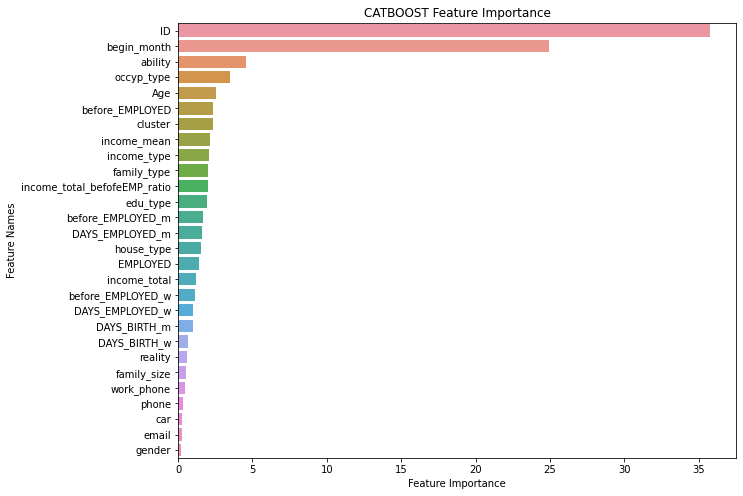

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## Submission

### submission 파일 불러오기

In [ ]:
sub = pd.read_csv(path + 'sample_submission.csv')

### submission 파일 저장

In [ ]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.115007,0.173187,0.711806
1,26458,0.338757,0.209268,0.451975
2,26459,0.036046,0.079928,0.884026
3,26460,0.054953,0.081003,0.864043
4,26461,0.083036,0.233750,0.683214
...,...,...,...,...
9995,36452,0.072545,0.223114,0.704341
9996,36453,0.326732,0.173392,0.499876
9997,36454,0.048996,0.118619,0.832385
9998,36455,0.144859,0.310712,0.544429


In [ ]:
sub.to_csv('submission0523_Final.csv', index=False)